In [1]:
import pandas as pd 


desktop_malware = pd.read_csv('../Datasets/JA4/Dataset2/desktop-malware.csv', sep=';')
desktop_apps_1 = pd.read_csv('../Datasets/JA4/Dataset2/desktop-apps.csv', sep=';')
desktop_apps_2 = pd.read_csv('../Datasets/JA4/Dataset1/Benign.csv', sep=';')
desktop_apps_3 = pd.read_csv('../Datasets/JA4/Dataset2/mydesktop-apps.csv', sep=';')
print(len(desktop_apps_3))

mobile_malware = pd.read_csv('../Datasets/JA4/Dataset2/mobile-malware.csv', sep=';')
mobile_apps = pd.read_csv('../Datasets/JA4/Dataset2/mobile-apps.csv', sep=';')

3766


In [2]:
drop_families = ["Sodinokibi", "Hawkeye", "Nanocore"]
desktop_malware = desktop_malware[~desktop_malware['AppName'].isin(drop_families)]

In [3]:
desktop_malware['label'] = 'DM'
desktop_apps_1['label'] = 'DA'
desktop_apps_2['label'] = 'DA'  # Asignamos DA si son aplicaciones benignas de escritorio
desktop_apps_3['label'] = 'DA'
mobile_malware['label'] = 'MM'
mobile_apps['label'] = 'MA'

df_combined = pd.concat([
    desktop_malware,
    desktop_apps_1,
    desktop_apps_2,
    desktop_apps_3,
    #mobile_malware,
    #mobile_apps
], ignore_index=True)

# Verificar las primeras filas
print(df_combined.head())

          SrcIP           DstIP  SrcPort  DstPort               SNI  \
0  10.127.0.236    77.88.21.158    49220      587               NaN   
1  10.127.0.236    77.88.21.158    49235      587               NaN   
2   10.127.0.88  204.79.197.200    50279      443  tse1.mm.bing.net   
3   10.127.0.88  204.79.197.200    50280      443  tse1.mm.bing.net   
4   10.127.0.88  204.79.197.237    50204      443        g.bing.com   

                              OrgName                           JA3hash  \
0                                 NaN                               NaN   
1                                 NaN                               NaN   
2  Microsoft Corporation, ECN-NETWORK  28a2c9bd18a11de089ef85a160da29e4   
3  Microsoft Corporation, ECN-NETWORK  28a2c9bd18a11de089ef85a160da29e4   
4  Microsoft Corporation, ECN-NETWORK  28a2c9bd18a11de089ef85a160da29e4   

                                JA4hash  AppName Type  \
0                                   NaN      NaN  NaN   
1       

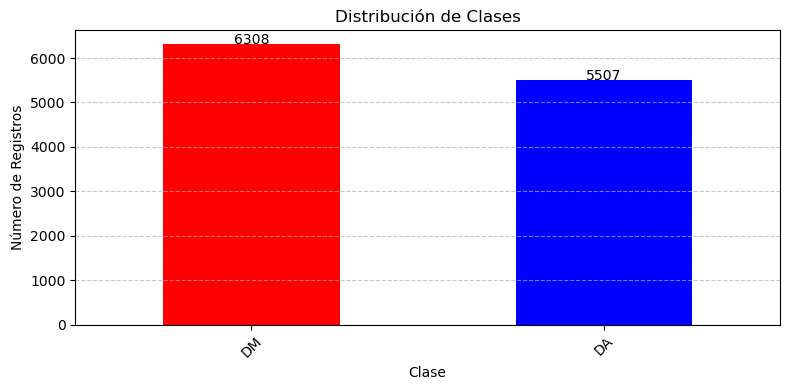

In [4]:
import matplotlib.pyplot as plt

# Contar registros por label
counts = df_combined['label'].value_counts()

# Gráfico de barras
plt.figure(figsize=(8, 4))
counts.plot(kind='bar', color=['red', 'blue', 'green', 'purple'])
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Número de Registros')

# Usar las categorías únicas de counts.index para los ticks
plt.xticks(ticks=range(len(counts)), labels=counts.index, rotation=45)  # <- Corrección aquí
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valores en las barras
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

In [5]:
df_hashing = df_combined.drop(columns=['SrcIP', 'DstIP', 'SrcPort', 'DstPort', 'OrgName', 'JA3hash', 'JA3Shash', 'Version', 'Issuer', 'Subject'])

print(df_hashing.columns)

Index(['SNI', 'JA4hash', 'AppName', 'Type', 'JA4Shash', 'Filename', 'JA4X',
       'label'],
      dtype='object')


In [6]:
df_combined["JA4+JA4S"] = df_combined["JA4hash"].astype(str) + "_" + df_combined["JA4Shash"].astype(str)

unique_fingerprints = df_combined["JA4+JA4S"].value_counts().to_dict()
print(f"JA4 JA4S unique fingerprints: {len(unique_fingerprints)}")

JA4 JA4S unique fingerprints: 494


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder
import joblib


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_combined['label'])

hasher = FeatureHasher(n_features=1024, input_type='string')
X = hasher.fit_transform(df_combined[['JA4hash', 'JA4Shash']].astype(str).values.tolist())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

featureHasher = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Para manejar desbalanceo
    random_state=42
)
featureHasher.fit(X_train, y_train)

joblib.dump(featureHasher, 'models/ja4.joblib')


y_pred_featureHasher = featureHasher.predict(X_test)
print(classification_report(y_test, y_pred_featureHasher))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1652
           1       0.98      0.92      0.95      1893

    accuracy                           0.95      3545
   macro avg       0.95      0.95      0.95      3545
weighted avg       0.95      0.95      0.95      3545



In [8]:
print(f"The score of the algorithm: {featureHasher.score(X_test,y_test)*100}")

The score of the algorithm: 95.11988716502115


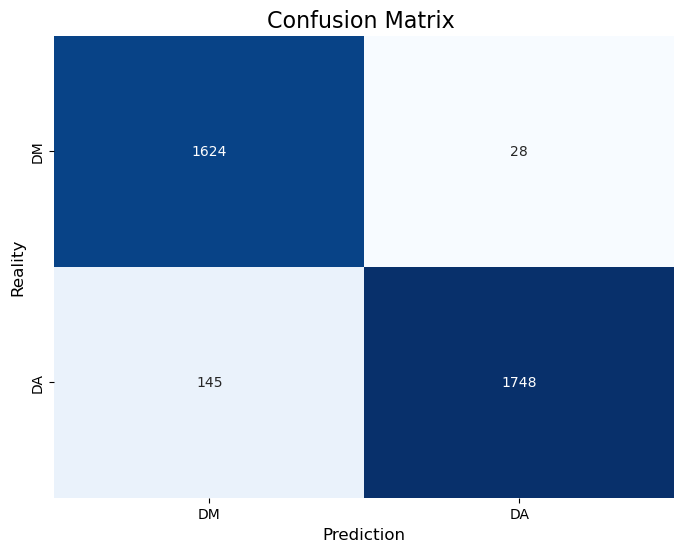

In [9]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_featureHasher)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df_combined['label'].unique(), yticklabels=df_combined['label'].unique(), cbar=False)
plt.title('Confusion Matrix ', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Reality', fontsize=12)


plt.show()

In [10]:
accuracy = accuracy_score(y_test, y_pred_featureHasher)
precision = precision_score(y_test, y_pred_featureHasher, average='macro')  # Puedes usar 'micro', 'macro', 'weighted' 
recall = recall_score(y_test, y_pred_featureHasher, average='macro')
f1 = f1_score(y_test, y_pred_featureHasher, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9512
Precision: 0.9511
Recall: 0.9532
F1 Score: 0.9511
